In [1]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import time
from datetime import datetime
import scipy.optimize as opt
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
plt.style.use("ggplot")
mpl.pyplot.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams["font.size"] = 13
#mpl.rcParams["font.family"] = 'Osaka'

## Real Prices

In [2]:
path = '../data/BTCdata_2.csv'
df_BTC = pd.read_csv(path, header=0)
df_BTC = df_BTC.rename(columns={'unixtime_precise': 'unixtime'})
df_BTC = df_BTC.loc[: ,['height', 'unixtime', 'Open', 'High', 'Low', 'Close', 'probability of success /Eh', 'expected return (USD/Eh)']]
df_BTC['time'] = pd.to_datetime(df_BTC['unixtime'].astype(int), unit='s')
df_BTC = df_BTC.sort_values(by='height', ascending=True)
df_BTC.head()

,height,unixtime,Open,High,Low,Close,probability of success /Eh,expected return (USD/Eh),time
0,450001,1485382343,896.66,896.66,895.43,895.44,0.000593,6.935004,2017-01-25 22:12:23
1,450002,1485383957,895.44,895.86,893.23,894.97,0.000593,7.424957,2017-01-25 22:39:17
2,450003,1485384299,895.44,895.86,893.23,894.97,0.000593,7.184180,2017-01-25 22:44:59
3,450004,1485384419,895.44,895.86,893.23,894.97,0.000593,7.025926,2017-01-25 22:46:59
4,450005,1485384847,895.44,895.86,893.23,894.97,0.000593,7.086069,2017-01-25 22:54:07


* Prices were recorded hourly.
* Simulation starts from the block with height 551443.

In [3]:
df_BTC[df_BTC['height'].isin([551442])]

,height,unixtime,Open,High,Low,Close,probability of success /Eh,expected return (USD/Eh),time
101441,551442,1543137762,3685.01,3700.28,3591.11,3604.59,0.000035,1.577661,2018-11-25 09:22:42


* The unit of `unixtime` is a second.
* Our simulation lasts 84 days, which is equivalent to 84 x 1440 x 60 seconds.

In [4]:
sim_length = 84*1440*60
start_unixtime = 1543137762
df_BTC_sim_period = df_BTC[df_BTC['unixtime']>=start_unixtime]
df_BTC_sim_period = df_BTC_sim_period[df_BTC_sim_period['unixtime']<=start_unixtime + sim_length]
df_BTC_sim_period.head()

,height,unixtime,Open,High,Low,Close,probability of success /Eh,expected return (USD/Eh),time
101441,551442,1543137762,3685.01,3700.28,3591.11,3604.59,0.000035,1.577661,2018-11-25 09:22:42
101442,551443,1543137894,3685.01,3700.28,3591.11,3604.59,0.000035,1.584459,2018-11-25 09:24:54
101443,551444,1543138811,3604.59,3677.84,3473.00,3645.60,0.000035,1.631278,2018-11-25 09:40:11
101444,551445,1543138983,3604.59,3677.84,3473.00,3645.60,0.000035,1.602982,2018-11-25 09:43:03
101445,551446,1543139843,3604.59,3677.84,3473.00,3645.60,0.000035,1.627151,2018-11-25 09:57:23


In [5]:
df_BTC_sim_period.tail()

,height,unixtime,Open,High,Low,Close,probability of success /Eh,expected return (USD/Eh),time
113414,563415,1550391691,3599.10,3600.47,3598.01,3598.02,0.000038,1.733188,2019-02-17 08:21:31
113415,563416,1550391772,3599.10,3600.47,3598.01,3598.02,0.000038,1.729134,2019-02-17 08:22:52
113416,563417,1550392109,3599.10,3600.47,3598.01,3598.02,0.000038,1.737419,2019-02-17 08:28:29
113417,563418,1550392145,3599.10,3600.47,3598.01,3598.02,0.000038,1.727610,2019-02-17 08:29:05
113418,563419,1550392681,3598.02,3600.30,3597.59,3600.18,0.000038,1.745050,2019-02-17 08:38:01


In [6]:
df_BTC_sim_period.to_csv('../data/BTC_sim_period.csv')

In [4]:
df_BTC_sim_period = pd.read_csv('../data/BTC_sim_period.csv', index_col=0)

* We will use the closing prices for our analysis.

In [7]:
prices_real = df_BTC_sim_period['Close'].values

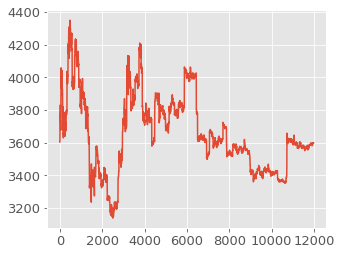

In [8]:
plt.plot(prices_real)
plt.show()

In [9]:
time_real = df_BTC_sim_period['unixtime'].values
time_real = time_real - time_real[0]
time_real = time_real/(1440*60)
time_real

array([ 0.   ,  0.002,  0.012, ..., 83.962, 83.963, 83.969])

* See how the real winning rate behaved.

In [10]:
winning_rates_real = df_BTC_sim_period['probability of success /Eh'].values

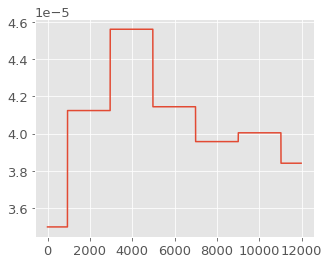

In [11]:
plt.plot(winning_rates_real)
plt.show()

## Comparison of Real Prices and Simulated Prices

In [12]:
# This path is used in the main text of our paper
df_exprvs = pd.read_csv('/Volumes/Data/research/BDA/simulation/sim_exprvs.csv')
df_price = pd.read_csv('/Volumes/Data/research/BDA/simulation/sim_prices_ps=0.csv')

In [13]:
no_iter = 3

prices = df_price.loc[:, 'iter_{}'.format(no_iter)]
exprvs = df_exprvs.loc[:,'iter_{}'.format(no_iter)]

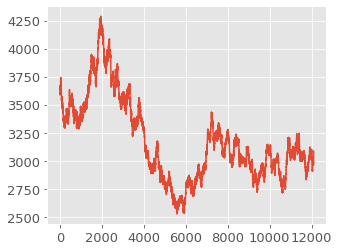

In [14]:
plt.plot(prices[:12096])
plt.show()

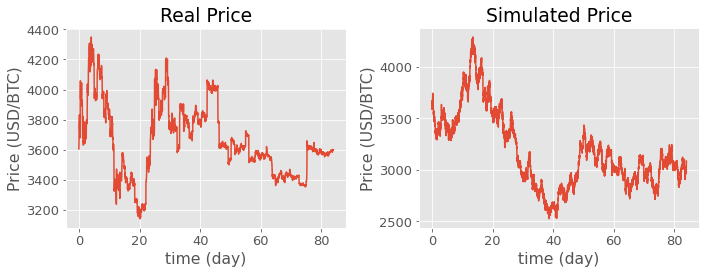

In [15]:
mpl.pyplot.rcParams['figure.figsize'] = (10.0, 4.0)

fig = plt.figure()
time = np.arange(12096)*10/1440
ax1 = fig.add_subplot(1,2,1)
ax1.plot(time_real, prices_real)
ax1.set_xlabel('time (day)')
ax1.set_ylabel('Price (USD/BTC)')
ax1.set_title('Real Price')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(time, prices[:12096])
ax2.set_xlabel('time (day)')
ax2.set_ylabel('Price (USD/BTC)')
ax2.set_title('Simulated Price')

plt.tight_layout()
fig.align_labels()
plt.show()

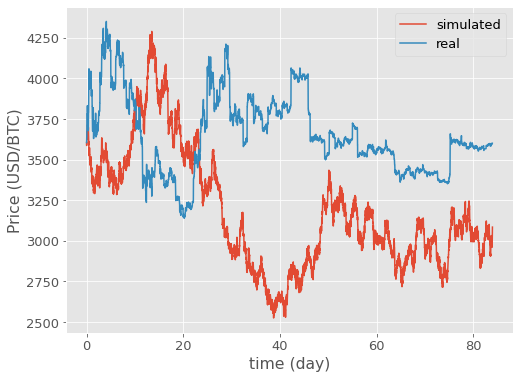

In [16]:
mpl.pyplot.rcParams['figure.figsize'] = (8.0, 6.0)

plt.plot(time, prices[:12096], label='simulated')
plt.plot(time_real, prices_real, label='real')
plt.xlabel('time (day)')
plt.ylabel('Price (USD/BTC)')
plt.legend(loc='best')
plt.show()

## Estimated Real Hashrates and Real Expected Rewards

In [5]:
df_real = pd.read_excel('../data/forscatterplot3.xlsx')

In [7]:
df_real = df_real.rename(columns={'unixtime_precise': 'unixtime'})
df_real.head()

,height,unixtime,time_precise,block_generation_time,probability of success /Eh,expected return (USD/Eh),adjusted block time,MA144,hashrate
0,543520,1538179345,2018-09-29 00:02:25.152,963,0.000033,2.708674,0.031347,NaN,NaN
1,543521,1538179517,2018-09-29 00:05:17.088,172,0.000033,2.688363,0.005599,NaN,NaN
2,543522,1538179809,2018-09-29 00:10:09.120,292,0.000033,2.681469,0.009505,NaN,NaN
3,543523,1538180877,2018-09-29 00:27:57.024,1068,0.000033,2.694467,0.034765,NaN,NaN
4,543524,1538180923,2018-09-29 00:28:42.816,46,0.000033,2.713028,0.001497,NaN,NaN


In [8]:
sim_length = 84*1440*60
start_unixtime = 1543137762
df_real_sim_period = df_real[df_real['unixtime']>=start_unixtime]
df_real_sim_period = df_real_sim_period[df_real_sim_period['unixtime']<=start_unixtime + sim_length]
df_real_sim_period.head()

,height,unixtime,time_precise,block_generation_time,probability of success /Eh,expected return (USD/Eh),adjusted block time,MA144,hashrate
7922,551442,1543137762,2018-11-25 09:22:41.664,26,0.000035,1.577661,0.000910,0.021363,46.809183
7923,551443,1543137894,2018-11-25 09:24:53.856,132,0.000035,1.584459,0.004619,0.021119,47.351058
7924,551444,1543138811,2018-11-25 09:40:11.424,917,0.000035,1.631278,0.032090,0.021293,46.964113
7925,551445,1543138983,2018-11-25 09:43:03.360,172,0.000035,1.602982,0.006019,0.021304,46.938934
7926,551446,1543139843,2018-11-25 09:57:23.040,860,0.000035,1.627151,0.030095,0.021418,46.690211


In [9]:
df_BTC_sim_period['Close']

101441    3604.59
101442    3604.59
101443    3645.60
101444    3645.60
101445    3645.60
           ...   
113414    3598.02
113415    3598.02
113416    3598.02
113417    3598.02
113418    3600.18
Name: Close, Length: 11978, dtype: float64

In [15]:
df_real_sim_period = df_real_sim_period.drop('Close (USD)', axis=1)
df_real_sim_period.head()

,height,unixtime,time_precise,block_generation_time,probability of success /Eh,expected return (USD/Eh),adjusted block time,MA144,hashrate
7922,551442,1543137762,2018-11-25 09:22:41.664,26,0.000035,1.577661,0.000910,0.021363,46.809183
7923,551443,1543137894,2018-11-25 09:24:53.856,132,0.000035,1.584459,0.004619,0.021119,47.351058
7924,551444,1543138811,2018-11-25 09:40:11.424,917,0.000035,1.631278,0.032090,0.021293,46.964113
7925,551445,1543138983,2018-11-25 09:43:03.360,172,0.000035,1.602982,0.006019,0.021304,46.938934
7926,551446,1543139843,2018-11-25 09:57:23.040,860,0.000035,1.627151,0.030095,0.021418,46.690211


In [16]:
df_real_sim_period['Close (USD)'] = df_BTC_sim_period['Close'].values
df_real_sim_period.head()

ValueError: Length of values (11978) does not match length of index (5017)

In [17]:
df_real_sim_period.tail()

,height,unixtime,time_precise,block_generation_time,probability of success /Eh,expected return (USD/Eh),adjusted block time,MA144,hashrate
12934,556454,1546298203,2018-12-31 23:16:42.816,294,0.000041,1.918427,0.012183,0.024980,40.031675
12935,556455,1546299695,2018-12-31 23:41:34.944,1492,0.000041,1.934937,0.061827,0.025393,39.380760
12936,556456,1546299762,2018-12-31 23:42:42.336,67,0.000041,1.917165,0.002776,0.025246,39.609492
12937,556457,1546300239,2018-12-31 23:50:39.264,477,0.000041,1.920990,0.019767,0.024872,40.205763
12938,556458,1546300592,2018-12-31 23:56:31.776,353,0.000041,1.918471,0.014628,0.024673,40.530404


野田さんのデータは12月末までしかないっぽい．自分で作る必要あり．

### Data Cleaning

We need to
* Estimate hash rates
* Adjust block generation time
* Compute estimated expected rewards

* Let the window length $T := 144$.
* The hash rate at height $n$ can be estimated by the following formula (cf. Eq. (5) in Section 2.2.1. of the paper):
\[
\hat{H}(n) := \left[ \frac{\sum_{s=n-T}^{n-1}W(s) B(s)}{T} \right]^{-1},
\]
where $W(s)$ is the winning rate at height $s$ and $B(s)$ is the block time at height $s$.
* Note that the unit of blocktime is minute and the unit of hashrate is Eh/s. We need to adjust the measurement units.

In [23]:
path = '../data/BTCdata_timeadjusted.csv'
df_BTC = pd.read_csv(path, header=0)
# df_BTC = df_BTC.rename(columns={'unixtime_precise': 'unixtime'})
# df_BTC = df_BTC.loc[: ,['height', 'unixtime', 'Close', 'probability of success /Eh', 'block_generation_time', 'expected return (USD/Eh)']]
# df_BTC['time'] = pd.to_datetime(df_BTC['unixtime'].astype(int), unit='s')
# df_BTC = df_BTC.sort_values(by='height', ascending=True)
df_BTC.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime
0,450001,1485382343,895.44,0.000593,6.935004,2017-01-25 22:12:23,1485382343,NaN
1,450002,1485383957,894.97,0.000593,7.424957,2017-01-25 22:39:17,1485383957,26.900000
2,450003,1485384299,894.97,0.000593,7.184180,2017-01-25 22:44:59,1485384299,5.700000
3,450004,1485384419,894.97,0.000593,7.025926,2017-01-25 22:46:59,1485384419,2.000000
4,450005,1485384847,894.97,0.000593,7.086069,2017-01-25 22:54:07,1485384847,7.133333


In [28]:
df_BTC['winrate*blocktime'] = df_BTC['probability of success /Eh'] * df_BTC['adjusted_blocktime']
df_BTC.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime,winrate*blocktime
0,450001,1485382343,895.44,0.000593,6.935004,2017-01-25 22:12:23,1485382343,NaN,NaN
1,450002,1485383957,894.97,0.000593,7.424957,2017-01-25 22:39:17,1485383957,26.900000,0.015938
2,450003,1485384299,894.97,0.000593,7.184180,2017-01-25 22:44:59,1485384299,5.700000,0.003377
3,450004,1485384419,894.97,0.000593,7.025926,2017-01-25 22:46:59,1485384419,2.000000,0.001185
4,450005,1485384847,894.97,0.000593,7.086069,2017-01-25 22:54:07,1485384847,7.133333,0.004227


In [44]:
window_length = 144
temp = df_BTC['winrate*blocktime'].rolling(window_length).mean()
hashrate_estimated = 1/temp
hashrate_estimated = hashrate_estimated/60 # adjust the measurement unit
df_BTC['hashrate_estimated'] = hashrate_estimated
df_BTC.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime,winrate*blocktime,hashrate_estimated
0,450001,1485382343,895.44,0.000593,6.935004,2017-01-25 22:12:23,1485382343,NaN,NaN,NaN
1,450002,1485383957,894.97,0.000593,7.424957,2017-01-25 22:39:17,1485383957,26.900000,0.015938,NaN
2,450003,1485384299,894.97,0.000593,7.184180,2017-01-25 22:44:59,1485384299,5.700000,0.003377,NaN
3,450004,1485384419,894.97,0.000593,7.025926,2017-01-25 22:46:59,1485384419,2.000000,0.001185,NaN
4,450005,1485384847,894.97,0.000593,7.086069,2017-01-25 22:54:07,1485384847,7.133333,0.004227,NaN


In [47]:
df_BTC.to_csv('../data/BTCdata_timeadjusted_hashestimated.csv', index=False)

In [45]:
sim_length = 84*1440*60
start_unixtime = 1543137762
df_BTC_sim_period = df_BTC[df_BTC['unixtime']>=start_unixtime]
df_BTC_sim_period = df_BTC_sim_period[df_BTC_sim_period['unixtime']<=start_unixtime + sim_length]
df_BTC_sim_period.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime,winrate*blocktime,hashrate_estimated
101441,551442,1543137762,3604.59,0.000035,1.577661,2018-11-25 09:22:42,1543137762,0.433333,0.000015,46.809131
101442,551443,1543137894,3604.59,0.000035,1.584459,2018-11-25 09:24:54,1543137894,2.200000,0.000077,47.351005
101443,551444,1543138811,3645.60,0.000035,1.631278,2018-11-25 09:40:11,1543138811,15.283333,0.000535,46.964061
101444,551445,1543138983,3645.60,0.000035,1.602982,2018-11-25 09:43:03,1543138983,2.866667,0.000100,46.938882
101445,551446,1543139843,3645.60,0.000035,1.627151,2018-11-25 09:57:23,1543139843,14.333333,0.000502,46.690159


In [46]:
df_BTC_sim_period.tail()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime,winrate*blocktime,hashrate_estimated
113414,563415,1550391691,3598.02,0.000038,1.733188,2019-02-17 08:21:31,1550391691,2.700000,0.000104,54.049059
113415,563416,1550391772,3598.02,0.000038,1.729134,2019-02-17 08:22:52,1550391772,1.350000,0.000052,54.150551
113416,563417,1550392109,3598.02,0.000038,1.737419,2019-02-17 08:28:29,1550392109,5.616667,0.000216,54.660594
113417,563418,1550392145,3598.02,0.000038,1.727610,2019-02-17 08:29:05,1550392145,0.600000,0.000023,54.778001
113418,563419,1550392681,3600.18,0.000038,1.745050,2019-02-17 08:38:01,1550392681,8.933333,0.000343,54.724426


In [48]:
df_BTC_sim_period.to_csv('../data/BTC_sim_period.csv')

### Plot

In [2]:
df_BTC_sim_period = pd.read_csv('../data/BTC_sim_period.csv', index_col=0)
df_BTC_sim_period.head()

,height,unixtime,price,probability of success /Eh,expected return (USD/Eh),time,adjusted_unixtime,adjusted_blocktime,winrate*blocktime,hashrate_estimated
101441,551442,1543137762,3604.59,0.000035,1.577661,2018-11-25 09:22:42,1543137762,0.433333,0.000015,46.809131
101442,551443,1543137894,3604.59,0.000035,1.584459,2018-11-25 09:24:54,1543137894,2.200000,0.000077,47.351005
101443,551444,1543138811,3645.60,0.000035,1.631278,2018-11-25 09:40:11,1543138811,15.283333,0.000535,46.964061
101444,551445,1543138983,3645.60,0.000035,1.602982,2018-11-25 09:43:03,1543138983,2.866667,0.000100,46.938882
101445,551446,1543139843,3645.60,0.000035,1.627151,2018-11-25 09:57:23,1543139843,14.333333,0.000502,46.690159


In [3]:
time_real = df_BTC_sim_period['unixtime'].values
time_real = time_real - time_real[0]
time_real = time_real/(1440*60)
time_real

array([ 0.   ,  0.002,  0.012, ..., 83.962, 83.963, 83.969])

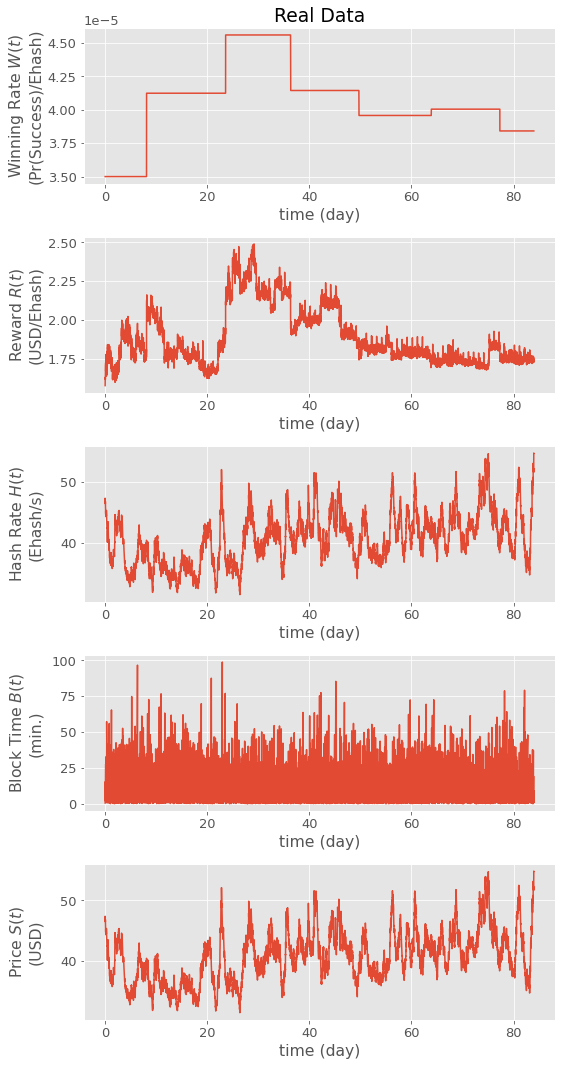

In [4]:
mpl.pyplot.rcParams['figure.figsize'] = (8.0, 15.0)

# 指数表示を禁止する方法がわからない(8/7)
np.set_printoptions(suppress=True)

win_rates = df_BTC_sim_period['probability of success /Eh'].values
rewards = df_BTC_sim_period['expected return (USD/Eh)'].values
hash_rates = df_BTC_sim_period['hashrate_estimated'].values
block_times = df_BTC_sim_period['adjusted_blocktime'].values
prices = df_BTC_sim_period['price'].values

fig = plt.figure()
ax1 = fig.add_subplot(5,1,1)
ax1.get_yaxis().get_major_formatter().set_useOffset(False)
ax1.plot(time_real, win_rates)
ax1.set_xlabel('time (day)')
ax1.set_ylabel('Winning Rate $W(t)$\n(Pr(Success)/Ehash)')
ax1.set_title('Real Data')

ax2 = fig.add_subplot(5,1,2)
ax2.plot(time_real, rewards)
ax2.set_xlabel('time (day)')
ax2.set_ylabel('Reward $R(t)$\n(USD/Ehash)')

ax3 = fig.add_subplot(5,1,3)
ax3.plot(time_real, hash_rates)
ax3.set_xlabel('time (day)')
ax3.set_ylabel('Hash Rate $H(t)$\n(Ehash/s)')

ax4 = fig.add_subplot(5,1,4)
ax4.plot(time_real, block_times)
ax4.set_xlabel('time (day)')
ax4.set_ylabel('Block Time $B(t)$\n(min.)')

ax5 = fig.add_subplot(5,1,5)
ax5.plot(time_real, hash_rates)
ax5.set_xlabel('time (day)')
ax5.set_ylabel('Price $S(t)$\n(USD)')


plt.tight_layout()
fig.align_labels()
plt.show()